In [1]:
from collections import Counter
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import (SMOTE, BorderlineSMOTE, SVMSMOTE, SMOTENC,
                                    KMeansSMOTE)
from imblearn.over_sampling import RandomOverSampler
from imblearn.base import BaseSampler
from fastai import *
from fastai.vision import *

In [2]:
path = datapath4file('306_kaggle')
tfms = get_transforms()
data = (ImageList.from_folder(path)
        .split_by_rand_pct(valid_pct=0.2)
        .label_from_folder()
        .transform(tfms, size=48)
        .databunch()).normalize(imagenet_stats)

print('train set: ' + str(len(data.train_ds)))
print('valid set: ' + str(len(data.valid_ds)))

train set: 30424
valid set: 7605


In [ ]:
data.train_ds

In [3]:
names = []
shapes = []
anger, happiness, sadness, neutral, disgust, fear, surprise = 0, 0, 0, 0, 0, 0, 0

for i in data.train_ds:
    # get the Image tensor to numpy array
    my_tensor = i[0].data.cpu().detach().numpy()
    # get batch, line, cols of the array
    batch, line, cols = my_tensor.shape
    # reshape
    to_be_used_in_resample = my_tensor.reshape(1,-1)
    # append the reshaped numpy array 
    shapes.append(to_be_used_in_resample)
    if str(i[1]) == 'surprise':
        surprise += 1
        names.append(6)
    if str(i[1]) == 'neutral':
        neutral += 1
        names.append(0)
    if str(i[1]) == 'anger':
        anger += 1
        names.append(1)
    if str(i[1]) == 'disgust':
        disgust += 1
        names.append(2)
    if str(i[1]) == 'fear':
        fear += 1
        names.append(3)
    if str(i[1]) == 'happiness':
        happiness += 1
        names.append(4)
    if str(i[1]) == 'sadness':
        sadness += 1
        names.append(5)
        
print('TRAIN SET')        
print('anger: ' + str(anger))
print('disgust: ' + str(disgust))
print('fear: ' + str(fear))
print('happiness: ' + str(happiness))
print('neutral: ' + str(neutral))
print('sadness: ' + str(sadness))
print('surprise: ' + str(surprise))

TRAIN SET
anger: 4217
disgust: 677
fear: 4324
happiness: 7458
neutral: 5192
sadness: 5113
surprise: 3443


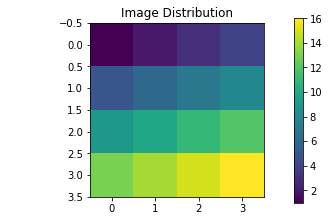

In [5]:
fig = plt.figure(figsize=(6, 3.2))
H = np.array([[1, 2, 3, 4],
              [5, 6, 7, 8],
              [9, 10, 11, 12],
              [13, 14, 15, 16]])  # added some commas and array creation code
ax = fig.add_subplot(111)
ax.set_title('Image Distribution')
plt.imshow(H)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()


In [4]:
def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)

In [5]:
def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

In [ ]:
# Make an identity sampler
class FakeSampler(BaseSampler):

    _sampling_type = 'bypass'

    def _fit_resample(self, X, y):
        return X, y

#comment out to resample
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

X = np.concatenate(shapes)

y = names
sampler = FakeSampler()
clf = make_pipeline(sampler, LinearSVC())
plot_resampling(X, y, sampler, ax1)
ax1.set_title('Original data - y={}'.format(Counter(y)))

ax_arr = (ax2, ax3, ax4)
for ax, sampler in zip(ax_arr, (RandomOverSampler(random_state=0),
                                SMOTE(random_state=0))):
    clf = make_pipeline(sampler, LinearSVC(max_iter=1200000))
    # reshape 
    # do resampling 
    # reshape back 
    # X = [i.reshape(batch, line, cols) for I in X]
    # get the data and send it to the model 
    
    clf.fit(X, y)
    plot_resampling(X, y, sampler, ax)
    ax.set_title('Resampling using {}'.format(sampler.__class__.__name__))
fig.tight_layout()

KeyboardInterrupt: 

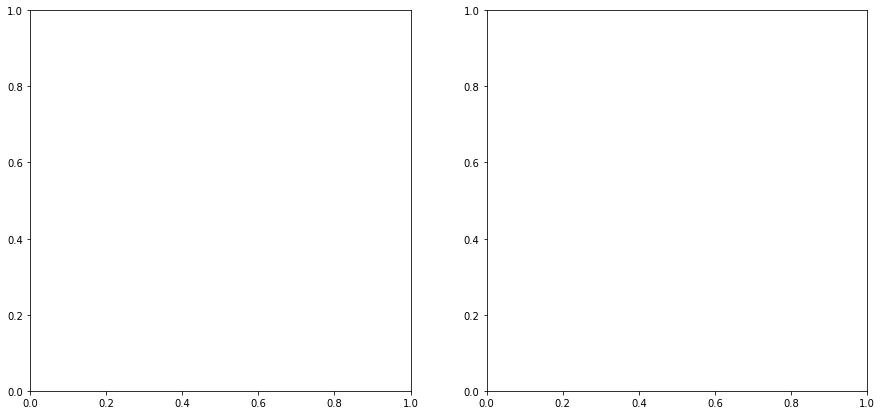

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
X, y = np.concatenate(shapes), names
clf = LinearSVC().fit(X, y)
plot_decision_function(X, y, clf, ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y)))
# pipe = make_pipeline(RandomOverSampler(random_state=0), LinearSVC())
# pipe.fit(X, y)
# plot_decision_function(X, y, pipe, ax2)
# ax2.set_title('Decision function for RandomOverSampler')
fig.tight_layout()